In [1]:
import sys
import numpy as np
import math
sys.path.append("../build/python")  # set to correct path for module
import varttpy

In [2]:
## IRLM model
L=100
t=0.5
V=0.15
U=-0.5

M=16

cc=np.loadtxt(f"cc_irlm_L{L}.txt")
eval,Q1 = np.linalg.eigh(cc)
ieval=np.argsort([-min(x,1-x) for x in eval])
Q=Q1[:,ieval]

## Kinetic energy TB Hamiltonian
K=np.zeros((L,L))
for i in range(1,L-1):
    K[i,i+1]=K[i+1,i]=t

K[0,1]=K[1,0]=V

## U ni nj
Umat=np.zeros((L,L))
Umat[0,1]=U
K[0,0]=K[1,1]=-U/2

## Diagonalize the bath
ek,R = np.linalg.eigh(K[2:,2:])
iek=np.argsort([abs(x) for x in ek])
Rfull=np.identity(L)
Rfull[2:,2:]=R[:,iek]
Krot = np.transpose(Rfull) @ K @ Rfull

## Diagonalize the bath again
Krot2=np.transpose(Q) @ Krot @ Q
ek,R = np.linalg.eigh(Krot2[M:,M:])
iek=np.argsort([abs(x) for x in ek])
Rfull=np.identity(L)
Rfull[M:,M:]=R[:,iek]
Q2 = Q @ Rfull



print("norm(QtQ-1)=", np.linalg.norm( np.transpose(Q) @ Q - np.identity(L)))
#print("Qt cc Q=", np.diag( np.transpose(Q) @ cc @ Q ))

model = varttpy.Fermionic(Krot,Umat, Q2)
H=model.Ham()
print("H: ",[M.shape[-1] for M in H.cores])

norm(QtQ-1)= 1.431813916108977e-14
H:  [4, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 44, 44, 44, 44, 44, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 39, 39, 39, 37, 37, 37, 37, 37, 37, 37, 35, 35, 35, 33, 33, 33, 31, 29, 27, 25, 23, 21, 19, 17, 15, 12, 7, 4, 1]


In [3]:
sol=varttpy.DMRG0(H)
sol.bond_dim=32
sol.nIter_diag=32
Npart=model.NParticle();
print("sweep energy Npart")
eners=[]
for i in range(5):
    sol.iterate()
    print(i+1, sol.energy, sol.Expectation(Npart))
    eners += [sol.energy]

variance_rel=sol.H2(4*sol.bond_dim)/sol.energy**2-1
print("H^2/E^2-1=", variance_rel)

sweep energy Npart
1 -31.250152172867207 50.00000010340285
2 -31.250152247202877 50.0000000000208
3 -31.250152247241658 49.99999999995366
4 -31.250152247249492 49.999999999953445
5 -31.250152247238322 49.99999999995182
6 -31.250152247253162 49.999999999953154
7 -31.250152247240294 49.99999999995484
8 -31.250152247235352 49.99999999995041
9 -31.250152247238493 49.99999999995354
10 -31.250152247239367 49.99999999995043
H^2/E^2-1= -1.2101430968414206e-14


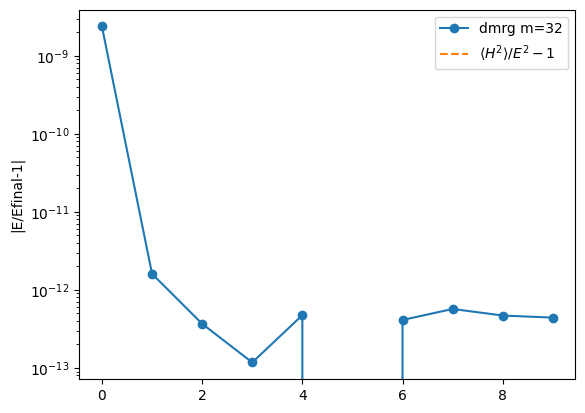

In [4]:
import matplotlib.pyplot as plt
plt.yscale('log')
eRef=np.min(eners)
plt.ylabel("|E/Efinal-1|")
plt.plot([abs(x/eRef-1) for x in eners], '-o', label=f'dmrg m={sol.bond_dim}')
plt.plot([variance_rel for x in eners], '--', label="$\\langle H^2 \\rangle /E^2-1$")
plt.legend()

In [5]:
from multiprocessing import Pool

ij_l=[]
for i in range(L):
    for j in range(i,L):
        ij_l += [[i,j]]

def f(ij):
    return sol.Expectation(model.CidCj(ij[0], ij[1]))

with Pool() as p:
    cc=(p.map(f, ij_l))

cmat=np.zeros((L,L))
c=0
for i in range(L):
    for j in range(i,L):
        cmat[i,j]=cmat[j,i]=cc[c]
        c=c+1
eval=np.sort( np.linalg.eigvals(cmat) )

/home/yurielnf/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


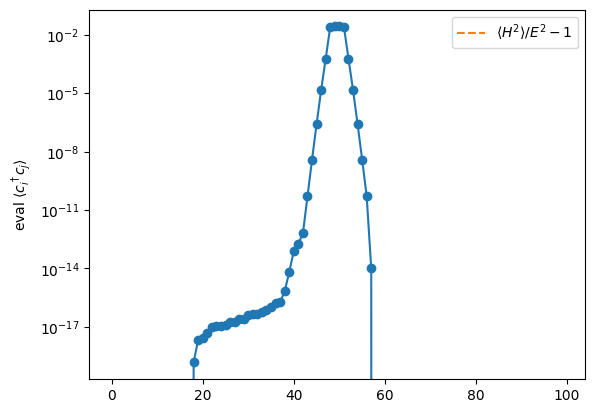

In [6]:
import matplotlib.pyplot as plt
plt.ylabel('eval $ \\langle c_i^\dagger c_j \\rangle$')
plt.yscale('log')
plt.plot([min(x,1-x) for x in eval], '-o')
plt.plot([variance_rel for x in eval], '--', label="$\\langle H^2 \\rangle /E^2-1$")
plt.legend()

In [28]:
print("Npart=",sol.Expectation(Npart))
print("H2-E^2 sigma/E")
ener=sol.Expectation(model.Ham())
m=sol.bond_dim
for mi in [m//2, m, 2*m, 3*m, 4*m]:
    print(sol.H2(mi)/ener**2-1, sol.sigma(mi)/sol.energy  )

Npart= 49.99999999995289
H2-E^2 sigma/E
4.079936388734495e-11 -7.078609170002423e-10
2.2426505097428162e-14 -5.214062785849667e-09
2.2426505097428162e-14 -1.8195122977564117e-08
2.2426505097428162e-14 -1.8760118361380134e-08
2.19824158875781e-14 -1.8770205669197048e-08


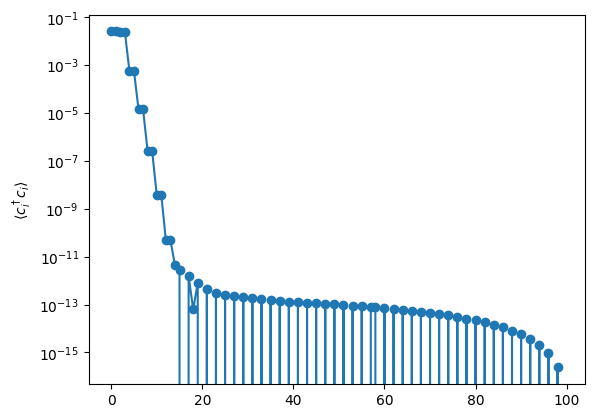

In [7]:
plt.ylabel('$ \\langle c_i^\dagger c_i \\rangle$')
plt.yscale("log")
plt.plot([min(x,1-x) for x in cmat.diagonal()], 'o-')

In [8]:
print("gs: ",[M.shape[-1] for M in sol.gs.cores])

gs:  [2, 4, 8, 16, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 8, 4, 2, 1]
